In [2]:
import jax.numpy as jnp
from jax import jit,grad,hessian,jacfwd
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt

import jax

key = jax.random.PRNGKey(420)
from scipy.interpolate import CloughTocher2DInterpolator

def resample(X,y,m_interp=40):
    interp = CloughTocher2DInterpolator(X, y,fill_value=0)
    xgrid,ygrid = np.linspace(0,1,m_interp),np.linspace(0,1,m_interp)
    meshX,meshY=np.meshgrid(xgrid,ygrid)
    return xgrid,ygrid,interp(meshX,meshY)
plt.style.use('ggplot')

from scipy.interpolate import RectBivariateSpline

In [3]:
im = plt.imread('face.png')


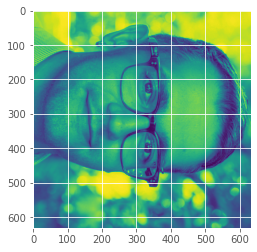

In [4]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray
bamdad_im=rgb2gray(im)[::-1,:632].T
plt.imshow(bamdad_im[::-1])

xbamdad,ybamdad=jnp.linspace(0,1,len(bamdad_im)),jnp.linspace(0,1,len(bamdad_im))

#Interpolate bamdad
bdSpline=RectBivariateSpline(xbamdad,ybamdad,bamdad_im)

In [5]:
def get_gaussianRBF(gamma):
    def f(x,y):
        return jnp.exp(-jnp.sum((x-y)**2)/gamma)
    return f

def minus_div(f,arg_num=0):
    jac=jacfwd(f,argnums=arg_num)
    def divergence(x,y):
        return -1*jnp.trace(jac(x,y))
    return divergence

def k_laplacian(f,arg_num=0):
    return minus_div(grad(f,argnums=arg_num),arg_num=arg_num)

def laplacian(f,arg_num=0):
    hess= hessian(f,argnums=arg_num)
    def lap(x):
        return -1*jnp.trace(hess(x))
    return lap

k= get_gaussianRBF(0.01)
k_lapx = k_laplacian(k,arg_num=0)
k_laplap = k_laplacian(k_lapx,arg_num=1)


vec_k = jax.vmap(jax.vmap(k, in_axes=(None,0)), in_axes=(0,None))
vec_k_lapx = jax.vmap(jax.vmap(k_lapx, in_axes=(None,0)), in_axes=(0,None))
vec_k_laplap = jax.vmap(jax.vmap(k_laplap, in_axes=(None,0)), in_axes=(0,None))



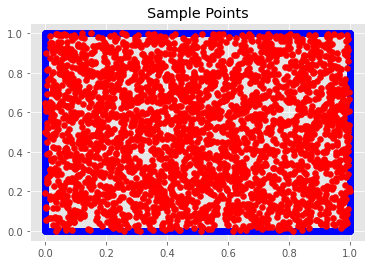

In [17]:
num_interior=3000

num_per_boundary=300
num_boundary=4*num_per_boundary


interior_points = jax.random.uniform(key,shape=(num_interior,2),minval=0,maxval=1)

boundary_point_samples=np.linspace(0,1,num_per_boundary)
boundary_points = np.hstack([
    np.vstack((np.zeros(num_per_boundary),boundary_point_samples)),
    np.vstack((np.ones(num_per_boundary),boundary_point_samples)),
    np.vstack((boundary_point_samples,np.ones(num_per_boundary))),
    np.vstack((boundary_point_samples,np.zeros(num_per_boundary)))
]).T

all_points = jnp.vstack([interior_points,boundary_points])

plt.title("Sample Points")
plt.scatter(boundary_points[:,0],boundary_points[:,1],c='blue')
plt.scatter(interior_points[:,0],interior_points[:,1],c='red')
plt.show()

In [18]:
K_bamdad=vec_k(all_points,all_points)
y_bamdad=bdSpline(all_points[:,0],all_points[:,1],grid=False)

bamdad_coeffs=jnp.linalg.solve(K_bamdad+1e-9*jnp.identity(len(K_bamdad)),y_bamdad)

def bamdad_func(X):
    return vec_k(X,all_points)@bamdad_coeffs

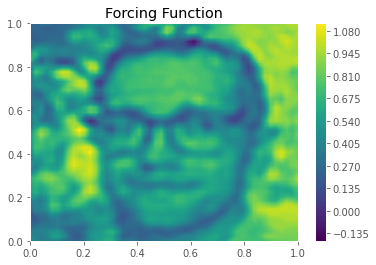

In [21]:
def true_solution_single(x):
    boundary_term = x[0]*(1-x[0])*x[1]*(1-x[1])
    interior = jnp.cos(5*jnp.pi*((0.5-x[0])**2 + (0.3*x[1])**2))
    return 4 * boundary_term * interior

def true_solution_single(x):
    return jnp.sin(3*jnp.pi*x[0])*jnp.sin(2*jnp.pi*x[1])


rhs_func = bamdad_func


m_interp=50
xgrid,ygrid = np.linspace(0,1,m_interp),np.linspace(0,1,m_interp)
meshX,meshY=np.meshgrid(xgrid,ygrid)

interpolation_points = jnp.vstack([meshX.flatten(),meshY.flatten()]).T

interp_rhs=(rhs_func(interpolation_points)).reshape(m_interp,m_interp)

plt.title("Forcing Function")
plt.contourf(meshX,meshY,interp_rhs,levels=100)
plt.colorbar()
plt.show()

In [23]:
K1 = vec_k_laplap(interior_points,interior_points)
K2 = vec_k_lapx(interior_points,boundary_points)
K3 = K2.T
K4 = vec_k(boundary_points,boundary_points)

K_full = jnp.block(
    [
        [K1,K2],
        [K3,K4]
    ]
)

interior_rhs = rhs_func(interior_points)
boundary_rhs = jnp.zeros(num_boundary)
rhs_total = jnp.hstack([interior_rhs,boundary_rhs])

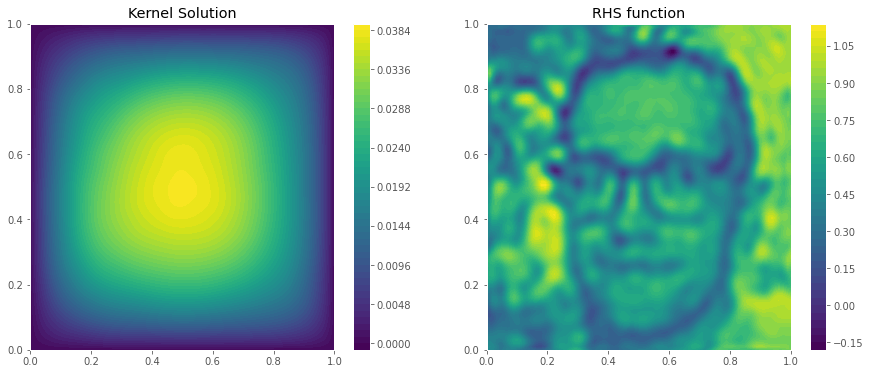

max norm residual and refined residual
0.0030832719057798386
0.0020647626370191574


In [27]:
nugget=1e-10
Kmat=K_full+nugget*jnp.diag(jnp.diag(K_full))
coef_sol=jax.scipy.linalg.solve(Kmat,rhs_total,assume_a='pos')
residual = rhs_total - K_full@coef_sol
coef_sol_refined=coef_sol+jax.scipy.linalg.solve(Kmat,residual,assume_a='pos')

residual_refined = rhs_total - K_full@coef_sol_refined

eval_K=vec_k(interior_points,all_points)
sol_vals = eval_K@coef_sol


num_grid_points=100
xgrid=jnp.linspace(0,1,num_grid_points)
ygrid=jnp.linspace(0,1,num_grid_points)

XX,YY=jnp.meshgrid(xgrid,ygrid)

interpolation_points = jnp.vstack([XX.flatten(),YY.flatten()]).T

interp_k = jnp.block(
    [
        [vec_k_lapx(interpolation_points,interior_points),vec_k(interpolation_points,boundary_points)]
    ]
)

interp_solution=(interp_k@coef_sol).reshape(num_grid_points,num_grid_points)
interp_solution_refined=(interp_k@coef_sol_refined).reshape(num_grid_points,num_grid_points)

interp_rhs = rhs_func(interpolation_points).reshape(num_grid_points,num_grid_points)

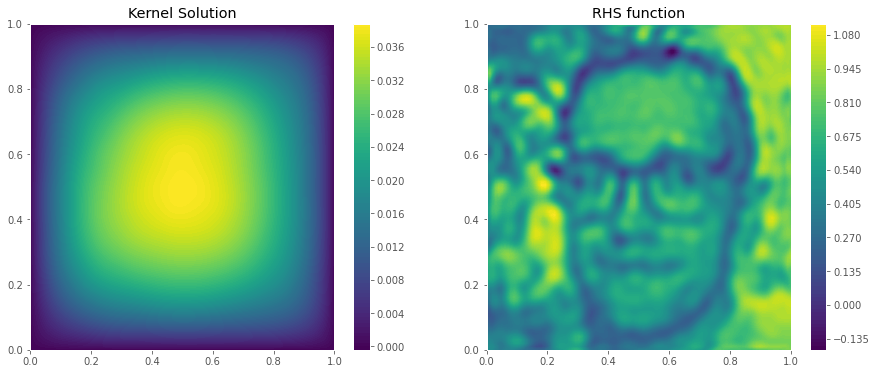

max norm residual and refined residual
0.0030832719057798386
0.0020647626370191574


In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
plot1=ax1.contourf(xgrid,ygrid,interp_solution,levels=100)
ax1.set_title("Kernel Solution")
plt.colorbar(plot1,ax=ax1)
plot2=ax2.contourf(xgrid,ygrid,interp_rhs,levels=100)
plt.colorbar(plot2,ax=ax2)

ax2.set_title("RHS function")
plt.savefig("bamdad_poisson.png")
plt.show()

print("max norm residual and refined residual")
print(jnp.max(jnp.abs(residual)))
print(jnp.max(jnp.abs(residual_refined)))

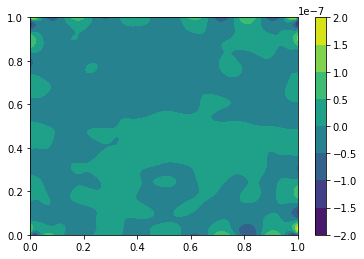

In [15]:
plt.contourf(XX,YY,error)
plt.colorbar()

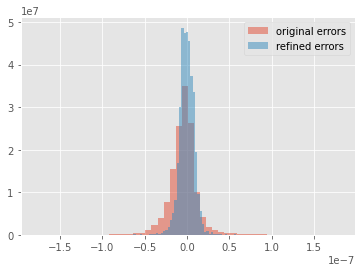

In [23]:
plt.hist(error.flatten(),50,alpha=0.5,density=True,label='original errors')
plt.hist(error_refined.flatten(),50,alpha=0.5,density=True,label='refined errors')
plt.legend()
plt.show()

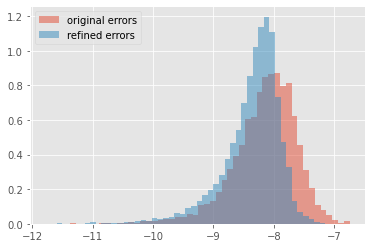

In [25]:
plt.hist(jnp.log10(jnp.abs(error.flatten()+1e-10)),50,alpha=0.5,density=True,label='original errors')
plt.hist(jnp.log10(jnp.abs(error_refined.flatten()+1e-10)),50,alpha=0.5,density=True,label='refined errors')
plt.legend()
plt.show()